# Segmentación semantica usando red neuronal convolucional Segnet

La segmentación semantica de una imagen consiste en asignar a cada pixel una clase usando un número entero. Por lo general, las clases se codifican en alguno de los canales RGB o se expresan mediante una ecuación donde se multiplican y suman los valores RGB de cada pixel.

La ventaja que representa una version segmentada de una imagen de forma semántica es que se puede describir usando lenguaje natural los objetos que se encuentran en la escena.

Para poder segmentar una imagen se debe usar una red neuronal convolucional con arquitectura similar a la de un autoencoder.

La red neuronal convolucional Segnet fue creada en la Universidad de Cambridge con el objetivo de realizar segmentación semántica de imágenes que son capturadas por vehículos autónomos.

### Acerca del dataset

El conjunto de imagenes que se usará lo provee https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge/home, el cual consiste de 5000 imagenes tomadas en el simulador de vehículos CARLA.

Cada una de las imagenes tiene un tamaño de 600x800 pixeles pero se escalan a 512x512 para mayor facilidad de manejo.

En total son 13 clases, representando con el número 0 a la nada:

1. Construcciones
2. Cercas
3. Otros
4. Peatones 
5. Postes 
6. Lineas de la carretera
7. Carretera
8. Banqueta
9. Vegetación
10. Vehículos
11. Paredes
12. Señal de tráfico

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
# Conversion de etiquetas a colores RGB
label2color = {
    0: (0, 0, 0),
    1: (70, 70, 70),
    2: (190, 153, 153),
    3: (250, 170, 160),
    4: (220,  20,  60), 
    5: (153, 153, 153), 
    6: (153, 153, 153), 
    7: (128, 64, 128), 
    8: (244, 35, 232),
    9: (107, 142, 35), 
    10: (0, 0, 142), 
    11: (102, 102, 156), 
    12:(220, 220, 0)
}

In [9]:
width = 512
height = 512

In [7]:
data_imgs = []
data_targets = []

path = '/floyd/input/carla_ds/dataset/'
img_names = os.listdir(path + 'data')
target_names = os.listdir(path + 'targets')

for img, target in zip(img_names[:3500], target_names[:3500]):
    im = cv2.imread(path + 'data/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_imgs.append(im)
    im = cv2.imread(path + 'targets/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_targets.append(im)
    
data_imgs = np.array(data_imgs)
data_targets = np.array(data_targets)

In [47]:
def label2image(img, num_classes=13, height=512, width=512):
    '''
        Toma como entrada una imagen con los valores de las clases 
        en cada pixel y regresa su representacion en colores RGB 
        para poder visualizar la segmentacion semantica.
    '''
    color_mask = np.zeros((height, width, 3), np.uint8())
    for i in range(0, num_classes):
        B, G = np.where(img==i) 
        for r, c in zip(B, G):
            red, green, blue = label2color[i]
            color_mask[r,c,0] = red
            color_mask[r,c,1] = green
            color_mask[r,c,2] = blue
    return color_mask

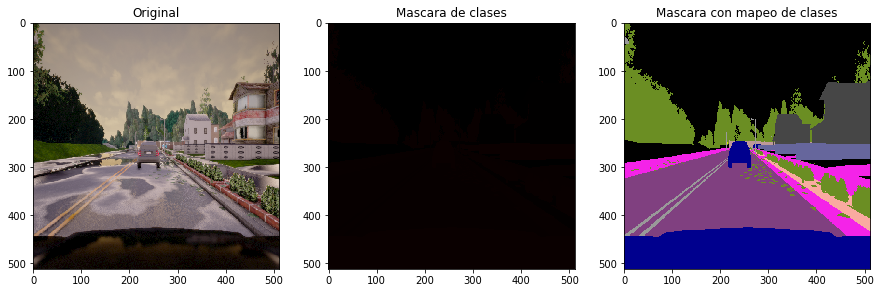

In [9]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(data_imgs[0])
plt.title('Original')
plt.subplot(132)
plt.title('Mascara de clases')
plt.imshow(data_targets[0])
plt.subplot(133)
plt.imshow(label2image(data_targets[0][:,:,0]))
plt.title('Mascara con mapeo de clases')
plt.show()
fig.savefig('test.png')

## Codificacion de las imagenes target

La entrada de la red neuronal convolucional es un tensor con dimensiones (height, widht, 3), la salida es un tensor con dimensiones (height, width, 13).

En este dataset, la imagen objetivo tiene las etiquetas de cada pixel codificadas en el canal rojo (como números enteros del 0 al 12), por lo que en principo tiene dimensiones (height, width, 3). Para que la red neuronal pueda ser entrenada, es necesario codificar la imagen objetivo o tensor con dimensiones (height, width, 13). 

One hot encoding es usado para codificar la imagen objetivo original en un tensor donde cada canal indica con 1's la clase de cada pixel.

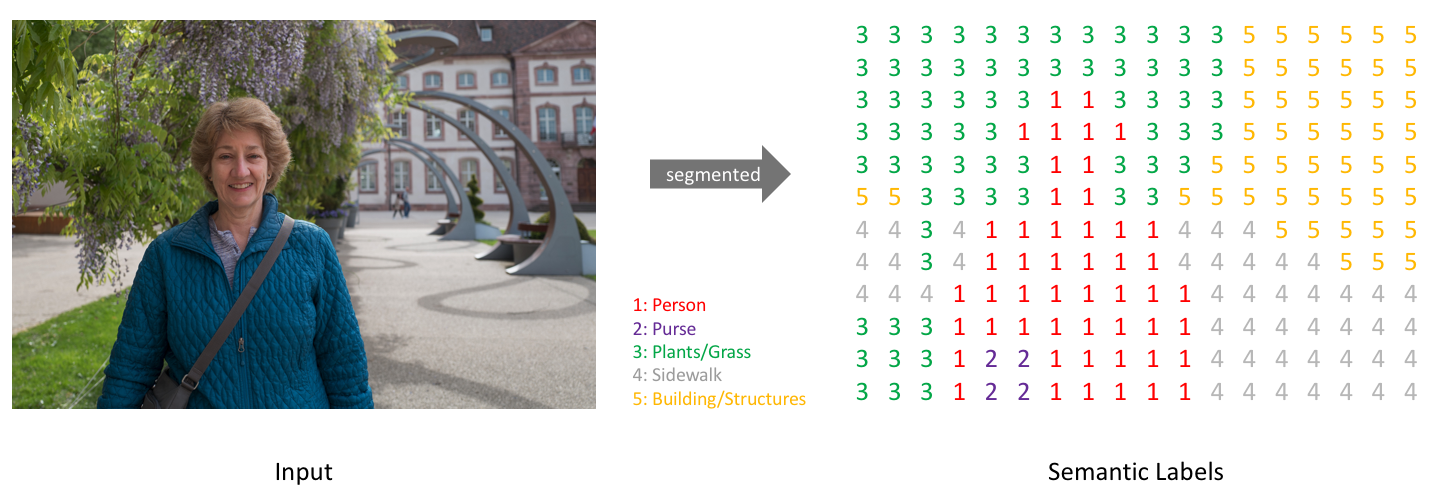

In [10]:
Image(filename="img/target_encoding.png", height=600, width=900)

One hot encoding


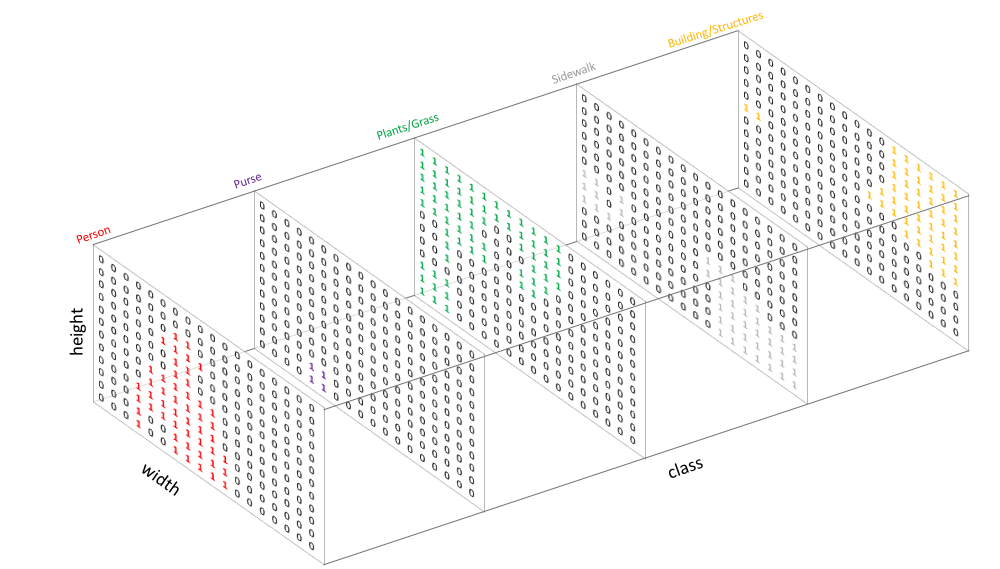

In [11]:
print('One hot encoding')
Image(filename="img/one_hot.png", height=500, width=900)

In [3]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
def one_hot_encode(imgs, height=512, width=512):
    one_hot = []
    for i in range(len(imgs)):
        im_class = to_categorical(imgs[i][:,:,0], dtype='uint8')
        if im_class.shape[2] < 13:
            while im_class.shape[2] < 13:
                zeros = np.zeros((height, width, 1), dtype='uint8')
                im_class = np.concatenate((im_class, zeros), axis=2)
        one_hot.append(im_class)
    return np.array(one_hot)

In [5]:
def make_mask(img):
    '''
        Entrada: Tensor de dimensiones (height, width, classes)
        Salida: Tensor de dimensiones (height, width)
        Se mapea la salida de la red neuronal a una sola matriz
        la cual contiene las clases de cada pixel. 
    '''
    return np.argmax(img, axis=-1)

In [7]:
targets_oneHot = one_hot_encode(data_targets)

(512, 512, 13)
(512, 512)
[[ 9  9  9 ...  0  0  0]
 [ 9  9  9 ...  0  0  0]
 [ 9  9  9 ...  0  0  0]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


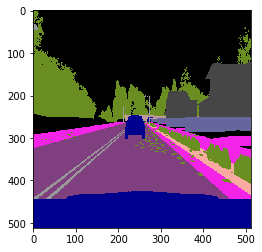

In [16]:
xx = targets_oneHot[0]
print(xx.shape)

yy = make_mask(xx)
print(yy.shape)

print(yy)

plt.figure()
plt.imshow(label2image(yy))
plt.show()

In [17]:
targets_oneHot.shape

(3500, 512, 512, 13)

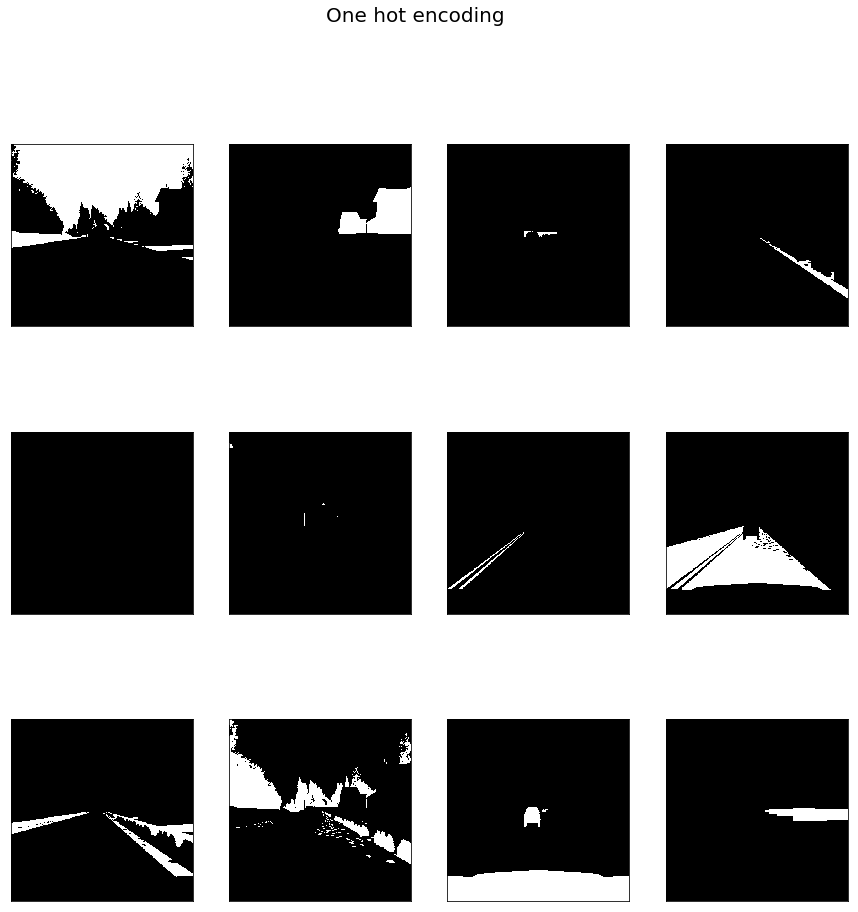

In [18]:
plt.figure(figsize=(15,15)).suptitle('One hot encoding', fontsize=20)
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(targets_oneHot[0][:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Creacion del modelo de red neuronal convolucional Segnet

La red neuronal convolucional Segnet tiene una arquitectura que consiste de dos etapas:

Codificador: Extraer los mapas de características de la imagen original mediante la convolución y reducir el tamaño haciendo un submuestreo mediante max pooling, guardando los índices de los pixeles con valor máximo resultantes para ser usados en la etapa de decodificación.

Decodificador: Reconstruir la imagen usando las características de baja resolución mediante el upsampling o *max unpooling* usando los índices de los pixeles guardados en la codificación. En la última capa, la función de activación softmax se usa para entregar a la salida una distribución de probabilidades que indica la pertenecia de un pixel a una de las 13 clases.

Batch normalization: Aplica una transformada a las activaciones de la capa de convolución para mantener la media cercana a 0 y la desviación estándar cercana a 1. Así se reduce el overfiting y se aumenta la rapidez de aprendizaje.

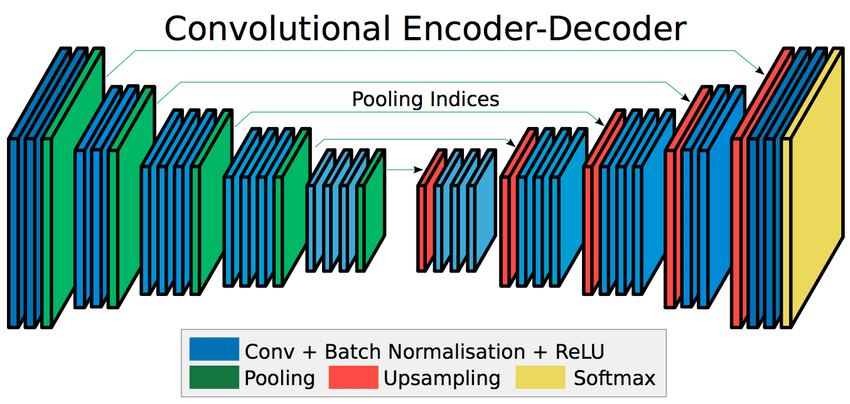

In [10]:
Image(filename='img/segnet.png', height=600, width=1024)

Upsampling


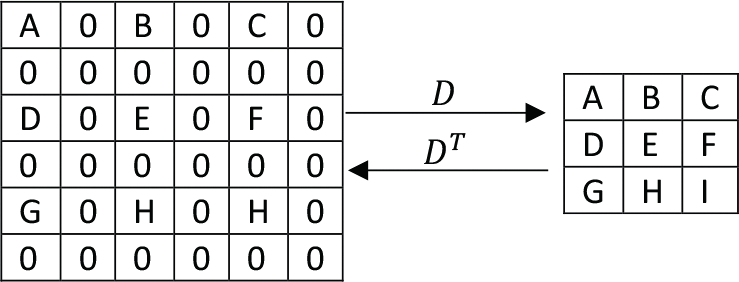

In [3]:
print('Upsampling')
Image(filename='img/upsampling.png')

In [17]:
from SegNet.model import segnet
from keras.optimizers import SGD

In [20]:
cnn = segnet(input_shape=(512, 512, 3), 
             n_labels=13,
             pool_size=(2, 2),
             output_mode='softmax')

Build enceder done..
Build decoder done..


In [21]:
cnn.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])

In [22]:
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
history = cnn.fit(data_imgs, targets_oneHot.reshape(3500, 262144, 13), validation_split=0.15, batch_size=5, epochs=10, shuffle=True)

Train on 2975 samples, validate on 525 samples
Epoch 1/10
2975/2975 [==============================] - 1904s 640ms/step - loss: 0.4334 - acc: 0.8694 - val_loss: 0.3108 - val_acc: 0.9061
Epoch 2/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.2230 - acc: 0.9314 - val_loss: 0.1900 - val_acc: 0.9410
Epoch 3/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.1640 - acc: 0.9487 - val_loss: 0.1905 - val_acc: 0.9381
Epoch 4/10
2975/2975 [==============================] - 1906s 641ms/step - loss: 0.1298 - acc: 0.9582 - val_loss: 0.1327 - val_acc: 0.9570
Epoch 5/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.1161 - acc: 0.9618 - val_loss: 0.1185 - val_acc: 0.9608
Epoch 6/10
2975/2975 [==============================] - 1906s 641ms/step - loss: 0.0959 - acc: 0.9676 - val_loss: 0.0999 - val_acc: 0.9661
Epoch 7/10
2975/2975 [==============================] - 1905s 640ms/step - loss: 0.0847 - acc: 0.9708 - val_loss: 0.088

In [27]:
os.mkdir('model')

In [30]:
cnn.save('model/model.h5')
cnn.save_weights('model/weights.h5')

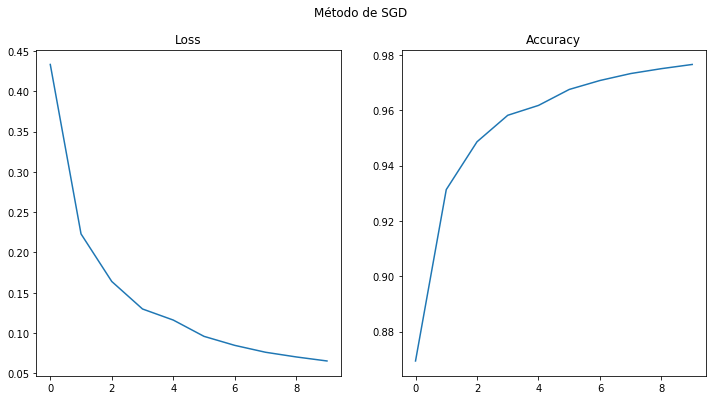

In [31]:
plt.figure(figsize=(12, 6)).suptitle('Método de SGD')
plt.subplot(121)
plt.plot(history.epoch, history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.epoch, history.history['acc'])
plt.title('Accuracy')
plt.show()

### Lectura del modelo y de los pesos

In [21]:
from keras import models
from SegNet.layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

In [22]:
custom_objects = {
    'MaxPoolingWithArgmax2D':MaxPoolingWithArgmax2D,
    'MaxUnpooling2D': MaxUnpooling2D
}

In [24]:
cnn = models.load_model('model/model.h5', custom_objects=custom_objects)
cnn.load_weights('model/weights.h5')

In [25]:
data_imgs = []
data_targets = []

path = '/floyd/input/carla_ds/dataset/'
img_names = os.listdir(path + 'data')
target_names = os.listdir(path + 'targets')

for img, target in zip(img_names[3500:], target_names[3500:]):
    im = cv2.imread(path + 'data/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_imgs.append(im)
    im = cv2.imread(path + 'targets/' + img, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (height, width), interpolation=cv2.INTER_NEAREST)
    data_targets.append(im)
    
data_imgs = np.array(data_imgs)
data_targets = np.array(data_targets)

In [26]:
targets_oneHot = one_hot_encode(data_targets)

In [27]:
loss, accuracy = cnn.evaluate(data_imgs, targets_oneHot.reshape(1500, 262144, 13))

1500/1500 [==============================] - 413s 275ms/step


In [29]:
print('Loss => %.2f' % loss)
print('Loss => %.2f' % (accuracy*100))

Loss => 0.07
Loss => 97.53


In [30]:
# Predecir las mascaras de segmentacion semantica del conjunto de prueba
label_prediction = cnn.predict(data_imgs)

In [84]:
print(label_prediction.shape)

(1500, 262144, 13)


In [48]:
segmented = []

for pred in label_prediction:
    mask = make_mask(pred.reshape(512, 512, 13))
    segmented.append(label2image(mask))

In [85]:
os.mkdir('predictions')

In [86]:
%%time
for im, target, pred, i in zip(data_imgs, targets_oneHot, segmented, range(len(segmented))):
    target = label2image(make_mask(target))
    image_block = np.hstack((im, target, pred))
    cv2.imwrite('predictions/' + 'test' + str(i+1) + '.png', cv2.cvtColor(image_block, cv2.COLOR_RGB2BGR))

CPU times: user 6min 20s, sys: 652 ms, total: 6min 20s
Wall time: 6min 19s


### Evaluacion del modelo
Se usara la *Intersection over Union* (IoU) para evaluar que tan buena es la prediccion hecha por la Segnet entrenada. 

La IoU se define como:

$$ IoU = \frac{target\cap prediction}{target\cup prediction} $$

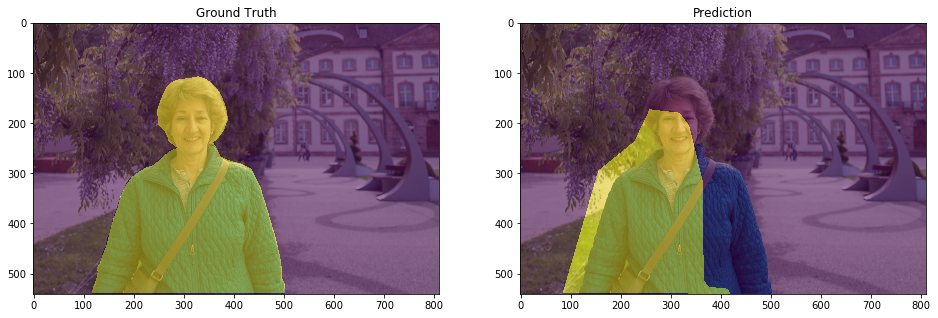

In [92]:
Image(filename='img/target_prediction.png')

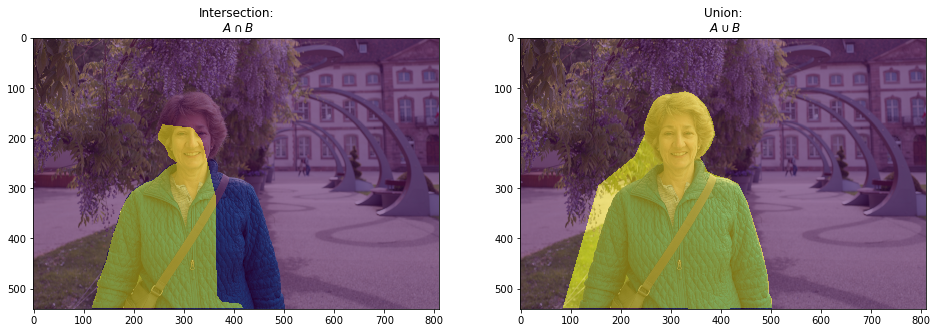

In [93]:
Image(filename='img/intersection_union.png')

In [91]:
IoU = []

for i in range(1500):
    intersection = np.logical_and(make_mask(targets_oneHot[i]), make_mask(label_prediction[i].reshape(512, 512, 13)))
    union = np.logical_or(make_mask(targets_oneHot[0]), make_mask(label_prediction[0].reshape(512, 512, 13)))
    IoU.append(np.sum(intersection) / np.sum(union))

In [95]:
IoU = np.array(IoU)

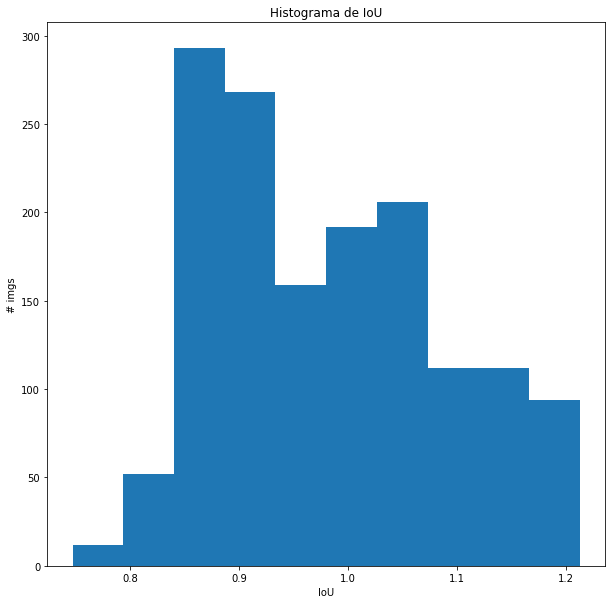

In [102]:
plt.figure(figsize=(10, 10))
plt.hist(IoU)
plt.title('Histograma de IoU')
plt.xlabel('IoU')
plt.ylabel('# imgs')
plt.show()

In [103]:
print('IoU promedio => %.4f' % np.mean(IoU))

IoU promedio => 0.9815


### Bibliografía 

segnet: https://arxiv.org/pdf/1511.00561.pdf 

batch normalization: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

semantic segmentation: https://www.jeremyjordan.me/semantic-segmentation/

segmentation: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf